In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import bokeh
from bokeh.layouts import Row, column, gridplot
from bokeh.models import Title, Legend, TapTool, Range1d, TabPanel, Tabs
import matplotlib as mpl

from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)
from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.models import Span


In [2]:
color_palette = [  '#4E79A7',  # Blue
    '#F28E2B',  # Orange
    '#E15759',  # Red
    '#76B7B2',  # Teal
    '#59A14F',  # Green
    '#EDC948',  # Yellow
    '#B07AA1',  # Purple
    '#FF9DA7',  # Pink
    '#9C755F',  # Brown
    '#BAB0AC',  # Gray
    '#7C7C7C',  # Dark gray
    '#6B4C9A',  # Violet
    '#D55E00',  # Orange-red
    '#CC61B0',  # Magenta
    '#0072B2',  # Bright blue
    '#329262',  # Peacock green
    '#9E5B5A',  # Brick red
    '#636363',  # Medium gray
    '#CD9C00',  # Gold
    '#5D69B1',  # Medium blue
]

In [3]:
bokeh.core.validation.silence(EMPTY_LAYOUT, True)

def get_line_plot(ooklaUsers,title, source, earthquakes=True, subtitle=None, measure = 'conflictIndex', category = 'ADM4_EN'):

    p2 = figure(x_axis_type = 'datetime', width = 1000, height = 400, toolbar_location='above')
    p2.add_layout(Legend(), "right")

    for id, adm2 in enumerate(ooklaUsers[category].unique()):
        df = ooklaUsers[ooklaUsers[category]==adm2][['event_date', measure]].reset_index(drop=True)
        p2.line(df['event_date'], df[measure], line_width=2, line_color = color_palette[id], legend_label=adm2)

    p2.legend.click_policy='hide'
    if subtitle is not None:
        p2.title = subtitle


    title_fig = figure(title=title, toolbar_location=None,width=800, height=40, )
    title_fig.title.align = "left"
    title_fig.title.text_font_size = "20pt"
    title_fig.border_fill_alpha = 0
    title_fig.outline_line_width=0

    #with silence(MISSING_RENDERERS):
    sub_title = figure(title=source, toolbar_location=None,width=800, height=40, )
    sub_title.title.align = "left"
    sub_title.title.text_font_size = "10pt"
    sub_title.title.text_font_style="normal"
    sub_title.border_fill_alpha = 0
    sub_title.outline_line_width=0

    layout = column(title_fig, p2, sub_title)

    if earthquakes:
        p2.renderers.extend([
        Span(
            location=datetime(2023, 10, 7),
            dimension="height",
            line_color='#7C7C7C',
            line_width=2,
            line_dash=(4,4)
      ),
        # Span(
        #     location=datetime(2021, 2, 15),
        #     dimension="height",
        #     line_color='#7C7C7C',
        #     line_width=2,
        #     line_dash=(4,4)
        # ),
    ]
)

    return layout

In [4]:
from shapely.geometry import Point

def convert_to_gdf(df, X=None, Y=None):
    if 'latitude' in df.columns:
        geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
        gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)
    else:
        geometry = [Point(xy) for xy in zip(df[Y], df[X])]
        gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)

    return gdf

# Conflict in the Gaza Strip

## Assignment
The purpose of this notebook is to identify the areas where there was potential conflict in Palestine, specifically in the Gaza Strip. To this end, multiple datasources were collated -- all of which show the part truth. 

## Data
1. ACLED: The Armed Conflict Location & Event Data Project (ACLED) is a disaggregated data collection, analysis, and crisis mapping project. ACLED collects information on the dates, actors, locations, fatalities, and types of all reported political violence and protest events around the world. The raw data is available through a license obtained by the World Bank. 

2. WorldPop: Estimated population density per grid-cell. The units are number of people per square kilometre based on country totals adjusted to match the corresponding official United Nations population estimates that have been prepared by the Population Division of the Department of Economic and Social Affairs of the United Nations Secretariat (2019 Revision of World Population Prospects).This data was produced in 2020. 

3. OpenStreetMaps: This is a crowdsourced dataset used to identify Points of Inetrest within Gaza. There is research that suggests that the OSM data for Israel is better than Gaza. However, it is currently the most accessible dataset we can use to estimate if Points of Interest took damage as a result of the attacks. 

## Limitations

ACLED is a crowdsourced dataset and is higly likely tat the numbers they are reporting are underreported. They keep changing their data based on local validation. OSM has multiple poliical and technical limitations for the current use case. However, it is one of the datasets that is publicly accessible and hence, is being used. Bittner (2017) outlined the Israeli domination of OSM entries, whereas there are far fewer mappers in Palestine


In [5]:
palestine_adm2 = gpd.read_file('../../data/shapefiles/pse_adm_pamop_20231019_shp/pse_admbnda_adm2_pamop_20231019.shp')
palestine_adm1 = gpd.read_file('../../data/shapefiles/pse_adm_pamop_20231019_shp/pse_admbnda_adm1_pamop_20231019.shp')
palestine_adm0 = gpd.read_file('../../data/shapefiles/pse_adm_pamop_20231019_shp/pse_admbnda_adm0_pamop_20231019.shp')

In [7]:
from datetime import datetime
acled = pd.read_csv('../../data/conflict/2004-01-01-2023-11-12-Palestine.csv')
acled['event_date'] = acled['event_date'].apply(lambda x: datetime.strptime(x, '%d %B %Y'))

In [8]:
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(acled.longitude, acled.latitude)]
acled = gpd.GeoDataFrame(acled, crs="EPSG:4326", geometry=geometry)

In [9]:
from scipy.stats import gmean

def get_acled_by_admin(adm, acled, columns = ['ADM4_EN','ADM3_EN','ADM2_EN', 'ADM1_EN'], nearest=False):
    if nearest == True:
        acled_adm2 = adm.sjoin_nearest(acled, max_distance=2000)[[ 'event_date', 'fatalities', 'event_type' ]+columns].groupby([pd.Grouper(key='event_date', freq='M', closed='left')]+columns)['fatalities'].agg(['sum', 'count']).reset_index()
    else:
        acled_adm2 = adm.sjoin(acled)[[ 'event_date', 'fatalities', 'event_type' ]+columns].groupby([pd.Grouper(key='event_date', freq='D', closed='left')]+columns)['fatalities'].agg(['sum', 'count']).reset_index()
    acled_adm2.rename(columns = {'sum':'fatalities', 'count':'nrEvents'}, inplace=True)
    #acled_adm2['event_date_map'] = acled_adm2['event_date'].apply(lambda x: x.date().replace(day=1))

    return acled_adm2.reset_index()

In [10]:
acled_adm0 = get_acled_by_admin(palestine_adm0, acled, columns = ['ADM0_EN'])

In [11]:
post_attack = acled[acled['event_date']>='2023-10-07']
post_attack = post_attack.groupby([pd.Grouper(key='event_date', freq='D', closed='left'), 'event_type', 'sub_event_type'])['fatalities'].agg(['sum', 'count']).reset_index()
post_attack.rename(columns = {'sum':'fatalities', 'count':'nrEvents'}, inplace=True)

In [12]:
output_notebook()
df = acled_adm0.groupby(['ADM0_EN', pd.Grouper(key='event_date', freq='M')]).sum(['fatalities', 'nrEvents']).reset_index()
show(get_line_plot(df, title = 'National Trends in Conflict Events', source= 'ACLED', category='ADM0_EN', measure = 'nrEvents'))

Loading BokehJS ...

In [13]:
output_notebook()
df = acled_adm0.groupby(['ADM0_EN', pd.Grouper(key='event_date', freq='M')]).sum(['fatalities', 'nrEvents']).reset_index()
show(get_line_plot(df, title = 'National Trends in Fatalities from Conflict Events', source= 'ACLED', category='ADM0_EN', measure = 'fatalities'))

Loading BokehJS ...

In [14]:
post_attack = acled[acled['event_date']>='2023-10-07']
post_attack = post_attack.groupby([pd.Grouper(key='event_date', freq='D', closed='left'), 'event_type', 'sub_event_type'])['fatalities'].agg(['sum', 'count']).reset_index()
post_attack.rename(columns = {'sum':'fatalities', 'count':'nrEvents'}, inplace=True)

In [15]:
df = post_attack.groupby(['event_date', 'event_type']).sum().reset_index()
show(get_line_plot(df, title = 'National Trends in Fatalities from Conflict Events in October 2023', source= 'ACLED', category='event_type', measure = 'fatalities'))

C:\Users\sahit\AppData\Local\Temp\ipykernel_22944\1685063018.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = post_attack.groupby(['event_date', 'event_type']).sum().reset_index()


In [16]:
population = pd.read_csv('../../data/population/pse_pd_2020_1km_UNadj_ASCII_XYZ/pse_pd_2020_1km_UNadj_ASCII_XYZ.csv')
population = convert_to_gdf(population, 'Y', 'X')

population_gaza = population.sjoin(palestine_adm1)
population_gaza = population_gaza[population_gaza['ADM1_EN']=='Gaza Strip']

In [196]:
print(f'There are roughly {round(population_gaza["Z"].sum()/1000000,2)} million people in the Gaza Strip')

There are roughly 2.52 million people in the Gaza Strip


Text(0, 0, 'Number of fatalities is on the marker size while color is showing number of conflict events. \n Source: Conflict data from ACLED. Shapefiles from HdX. Population from WorldPop Estimates')

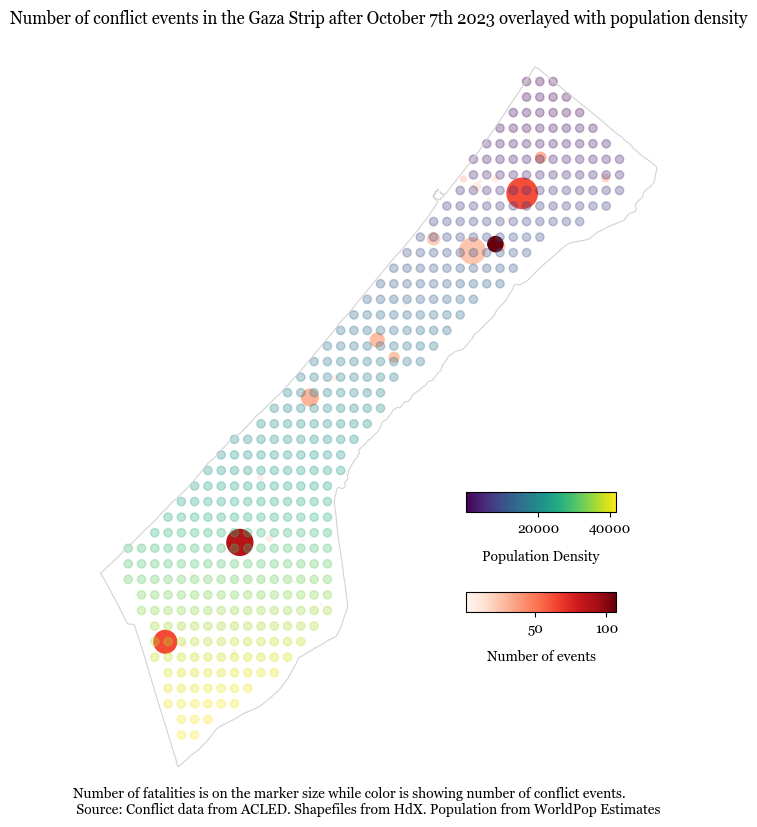

In [177]:
plt.rcParams["font.family"] = "Georgia"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
df = acled[acled['event_date']>='2023-10-07'].sjoin(palestine_adm1).groupby(['latitude', 'longitude', 'ADM1_EN'])['fatalities'].agg(['sum', 'count']).reset_index()
df.rename(columns = {'sum':'fatalities', 'count':'nrEvents'}, inplace=True)
df = df[df['ADM1_EN']=='Gaza Strip']
df = convert_to_gdf(df)


palestine_adm1[palestine_adm1['ADM1_EN']=='Gaza Strip'].boundary.plot(ax=ax, linewidth = 0.8, color = 'lightgrey')
df.plot(column='nrEvents', cmap='Reds', ax=ax, markersize='fatalities')
population_gaza.plot(cmap='viridis', ax=ax, alpha=0.3, legend = True)

cax = fig.add_axes([0.6, 0.3, 0.15, 0.02])
norm = plt.Normalize(vmin=df['nrEvents'].min(), vmax=df['nrEvents'].max())
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Reds'), ax=ax, orientation='horizontal', pad=0.02, aspect = 200, cax=cax)
cbar.set_label('Number of events', rotation=0, labelpad=10)

cax = fig.add_axes([0.6, 0.4, 0.15, 0.02])
norm = plt.Normalize(vmin=population_gaza['Z'].min(), vmax=population_gaza['Z'].max())
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, orientation='horizontal', pad=0.02, aspect = 200, cax=cax)
cbar.set_label('Population Density', rotation=0, labelpad=10)

ax.axis('off')

ax.set_title("Number of conflict events in the Gaza Strip after October 7th 2023 overlayed with population density")

subtitle = f'Number of fatalities is on the marker size while color is showing number of conflict events. \n Source: Conflict data from ACLED. Shapefiles from HdX. Population from WorldPop Estimates'

ax.text(0, 0, subtitle, ha='left', va='center', transform=ax.transAxes,
        fontsize=10, color='black', weight='normal')


In [48]:
acled['event_type'].unique()

cmap_dict = {'Explosions/Remote violence':'red', 'Strategic developments':'purple',
       'Violence against civilians':'yellow', 'Riots':'orange', 'Protests':'green', 'Battles':'black'}

Text(0, 0, 'Number of fatalities is on the marker size while color is showing number of conflict events. \n Source: Conflict data from ACLED. Shapefiles from HdX. Population from WorldPop Estimates')

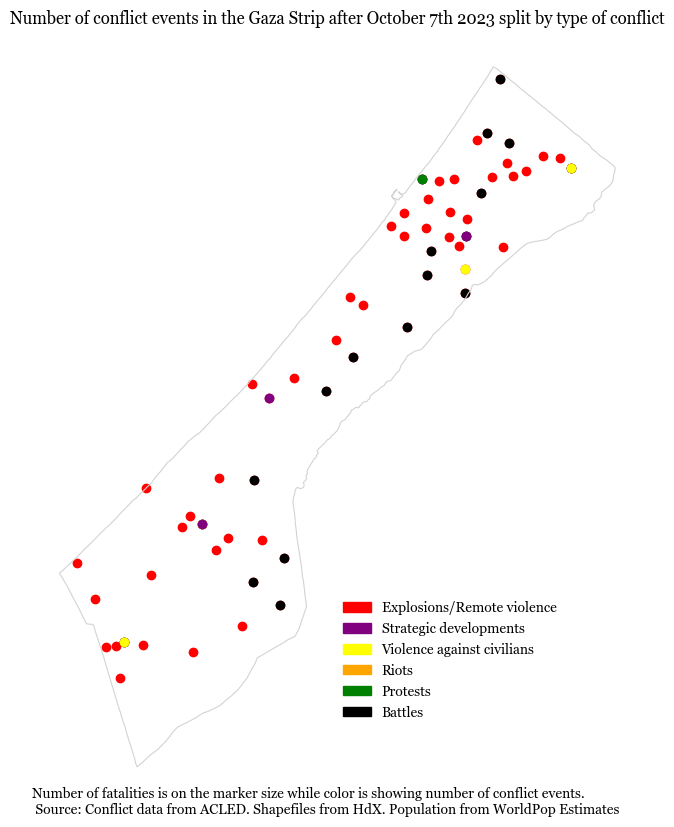

In [49]:
plt.rcParams["font.family"] = "Georgia"

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
df = acled[acled['event_date']>='2023-10-07'].sjoin(palestine_adm1).groupby(['latitude', 'longitude', 'ADM1_EN', 'event_type'])['fatalities'].agg(['sum', 'count']).reset_index()
df.rename(columns = {'sum':'fatalities', 'count':'nrEvents'}, inplace=True)
df = df[df['ADM1_EN']=='Gaza Strip']
df = convert_to_gdf(df)


palestine_adm1[palestine_adm1['ADM1_EN']=='Gaza Strip'].boundary.plot(ax=ax, linewidth = 0.8, color = 'lightgrey')

for event_type in df['event_type'].unique():
    df[df['event_type']==event_type].plot(color=cmap_dict[event_type], ax=ax,  label = event_type)

import matplotlib.patches as mpatches

patches = [mpatches.Patch(color=color, label=t) for t, color in cmap_dict.items()]
ax.legend(handles=patches, loc=(0.5, 0.1), frameon=False)


ax.axis('off')

ax.set_title("Number of conflict events in the Gaza Strip after October 7th 2023 split by type of conflict")

subtitle = f'Number of fatalities is on the marker size while color is showing number of conflict events. \n Source: Conflict data from ACLED. Shapefiles from HdX. Population from WorldPop Estimates'

ax.text(0, 0, subtitle, ha='left', va='center', transform=ax.transAxes,
        fontsize=10, color='black', weight='normal')


In [65]:
acled['event_timestamp'] = acled['event_date'].apply(lambda x: x.timestamp())
acled.to_csv('../../data/conflict/acled_processed_14_11_2023.csv')

In [17]:
poi = gpd.read_file('../../data/hotosm_pse_points_of_interest_points_shp/hotosm_pse_points_of_interest_points.shp')

In [76]:
poi_category = {'health' : ['hospital', 'pharmacy', 'doctors', 'dentist', 'clinic','nursing_home', ],
'places_of_economy' : ['restaurant','company', 'fast_food',  'cafe','biergarten','pub','factory','office','bar', 'cafe;restaurant', 'ice_cream','food_court','ice_cream;cafe',],
'refugee_locations' : ['refugee_site',  'refugee_camp',],
'financial_services' : ['atm','post_office',  'bank', 'bureau_de_change','money_transfer', 'payment_terminal', ],
'education' : ['college','school' , 'kindergarten', 'university','cooking_school',
       'music_school', ],
'essential_services' : ['police','toilets',  'fire_station',  'water_point',  'drinking_water', 'fuel'],
'religious_objects' : ['monastery', 'sacred_object','place_of_worship'],
'other' : ['bench', 'parking', 'public_building', 'shelter', 'townhall', 'arts_centre', 'library', 'nightclub',
       'car_rental', 'car_wash', 'grave_yard','courthouse','vending_machine','car_sharing',
       'conference_centre', 'marketplace', 'fountain', 'prison',
       'telephone', 'theatre', 'veterinary', 'bicycle_rental', 'recycling','studio',
       'community_centre', 'social_facility', 'Association', 'association', 'Photography studio', 'License', 'printer','driving_school','Housing Comlex', 'cinema', 'waste_basket', 'waste_disposal',
       "children's home", 'parking_entrance', 'bicycle_parking', 'bbq',
       'yes', 'compressed_air', 'NGO','shower',
       'childcare', 'events_venue', 'bicycle_repair_station', 'disused',
       'internet_cafe', 'social_centre','charging_station', 'public_bath', 
       'casino', 'motorcycle_parking', 'hunting_stand','public_bookcase', 'animal_breeding','clock', 'parking_space', 'planetarium',
       'feeding_place', 'letter_box', 'parcel_locker', 'reception_desk',
       'binoculars', 'embassy', 'boat_rental', 'bus_station', 'taxi' ],
'roads' : [ 'Road Services']
}

In [33]:
gaza = palestine_adm1[(palestine_adm1['ADM1_EN']=='Gaza Strip')]

In [41]:
def get_poi_category(x):
    for cat in list(poi_category.keys()):
        if x in poi_category[cat]:
            return cat

In [42]:
poi['poi_category'] = poi['amenity'].apply(lambda x: get_poi_category(x))

In [45]:
poi.to_file('../../data/hotosm_pse_points_of_interest_points_shp/poi_classification.shp', format = 'ESRI Shapefile')

C:\Users\sahit\AppData\Local\Temp\ipykernel_22944\44880883.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  poi.to_file('../../data/hotosm_pse_points_of_interest_points_shp/poi_classification.shp', format = 'ESRI Shapefile')


In [98]:
health_poi = poi[poi['amenity'].isin(health)].sjoin(palestine_adm1)
health_poi = health_poi[health_poi['ADM1_EN']=='Gaza Strip']

places_of_economy_poi = poi[poi['poi_category']=='places_of_economy'].sjoin(gaza)
schools_poi = poi[poi['poi_category']=='education'].sjoin(gaza)
financial_services_poi = poi[poi['poi_category']=='financial_services'].sjoin(gaza)
essential_services_poi = poi[poi['poi_category']=='essential_services'].sjoin(gaza)
refugee_locations_poi = poi[poi['poi_category']=='refugee_locations'].sjoin(gaza)

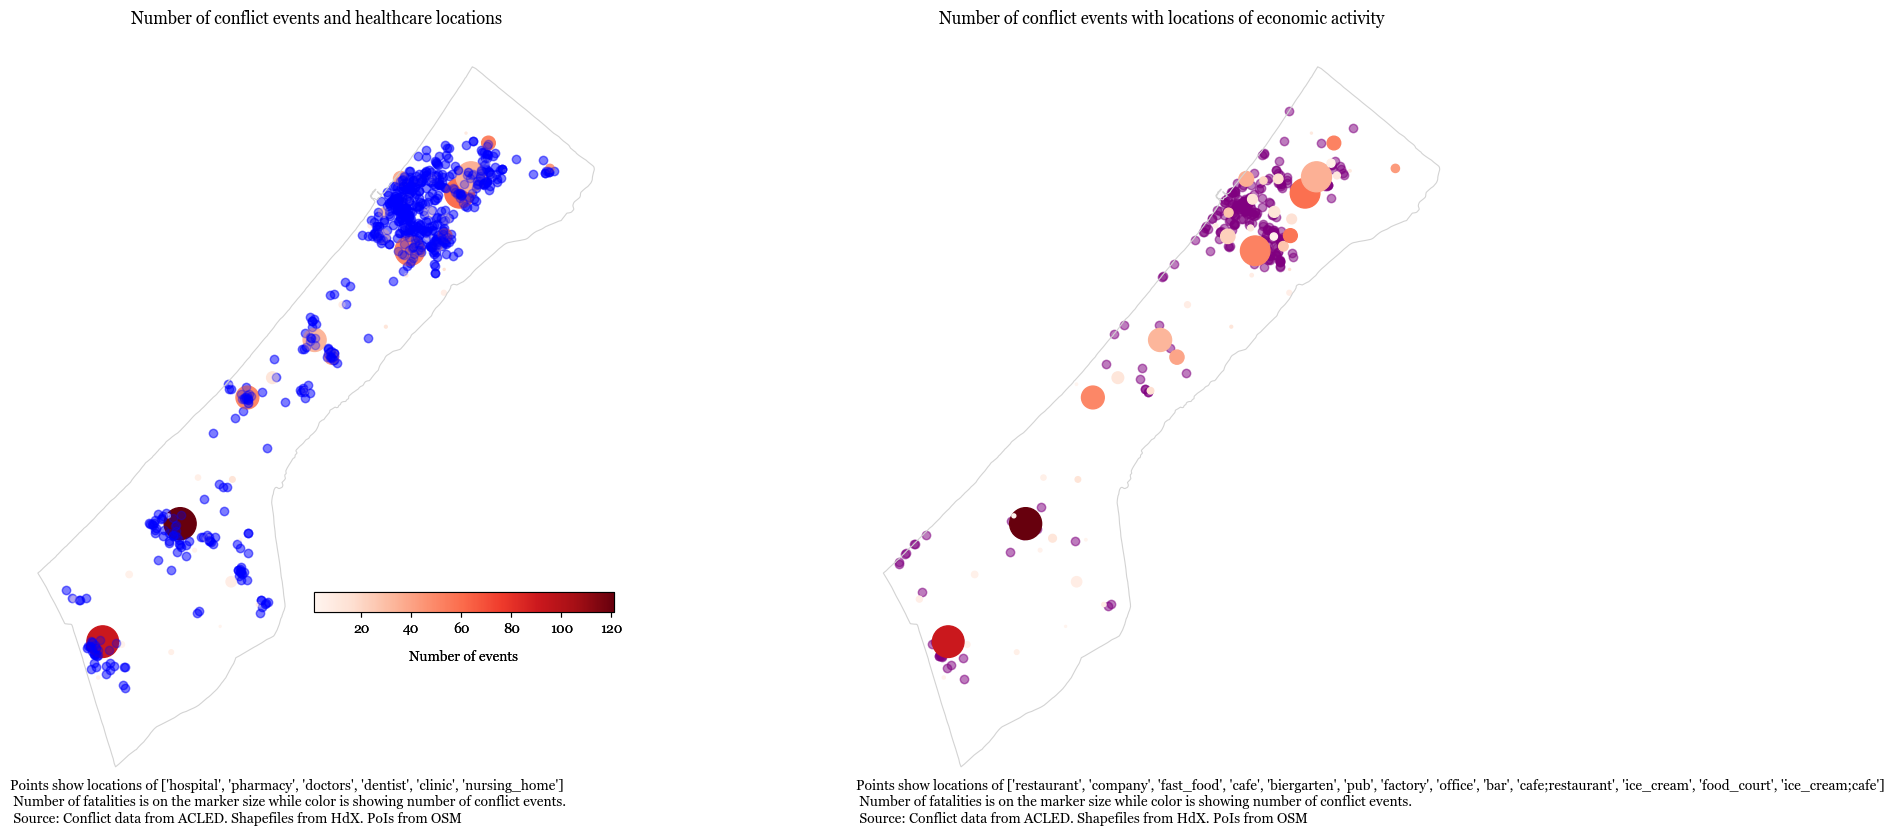

In [111]:
plt.rcParams["font.family"] = "Georgia"

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

df = acled[acled['event_date']>='2023-10-07'].sjoin(palestine_adm1).groupby(['latitude', 'longitude', 'ADM1_EN'])['fatalities'].agg(['sum', 'count']).reset_index()
df.rename(columns = {'sum':'fatalities', 'count':'nrEvents'}, inplace=True)
df = df[df['ADM1_EN']=='Gaza Strip']
df = convert_to_gdf(df)

for id, ax in enumerate(axs):
        palestine_adm1[palestine_adm1['ADM1_EN']=='Gaza Strip'].boundary.plot(ax=ax, linewidth = 0.8, color = 'lightgrey')
        
        health_poi.plot(color='blue', ax=axs[0], alpha=0.3, legend = True)
        places_of_economy_poi.plot(color='purple', ax=axs[1], alpha=0.3, legend = True)

        df.plot(column='nrEvents', cmap='Reds', ax=ax, markersize='fatalities')

        cax = fig.add_axes([0.3, 0.3, 0.15, 0.02])
        norm = plt.Normalize(vmin=df['nrEvents'].min(), vmax=df['nrEvents'].max())
        cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Reds'), ax=ax, orientation='horizontal', pad=0.02, aspect = 200, cax=cax)
        cbar.set_label('Number of events', rotation=0, labelpad=10)

        # cax = fig.add_axes([0.6, 0.4, 0.15, 0.02])
        # norm = plt.Normalize(vmin=population_gaza['Z'].min(), vmax=population_gaza['Z'].max())
        # cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, orientation='horizontal', pad=0.02, aspect = 200, cax=cax)
        # cbar.set_label('Population Density', rotation=0, labelpad=10)

        ax.axis('off')

        axs[0].set_title("Number of conflict events and healthcare locations")
        axs[1].set_title("Number of conflict events with locations of economic activity")
        
        if id == 0:
            subtitle_add_on = health
        else:
              subtitle_add_on = places_of_economy

        subtitle = f'Points show locations of {subtitle_add_on} \n Number of fatalities is on the marker size while color is showing number of conflict events. \n Source: Conflict data from ACLED. Shapefiles from HdX. PoIs from OSM'


        ax.text(0, 0, subtitle, ha='left', va='center', transform=ax.transAxes,
                fontsize=10, color='black', weight='normal')

plt.savefig('../../docs/images/conflict_on_poi1.png')

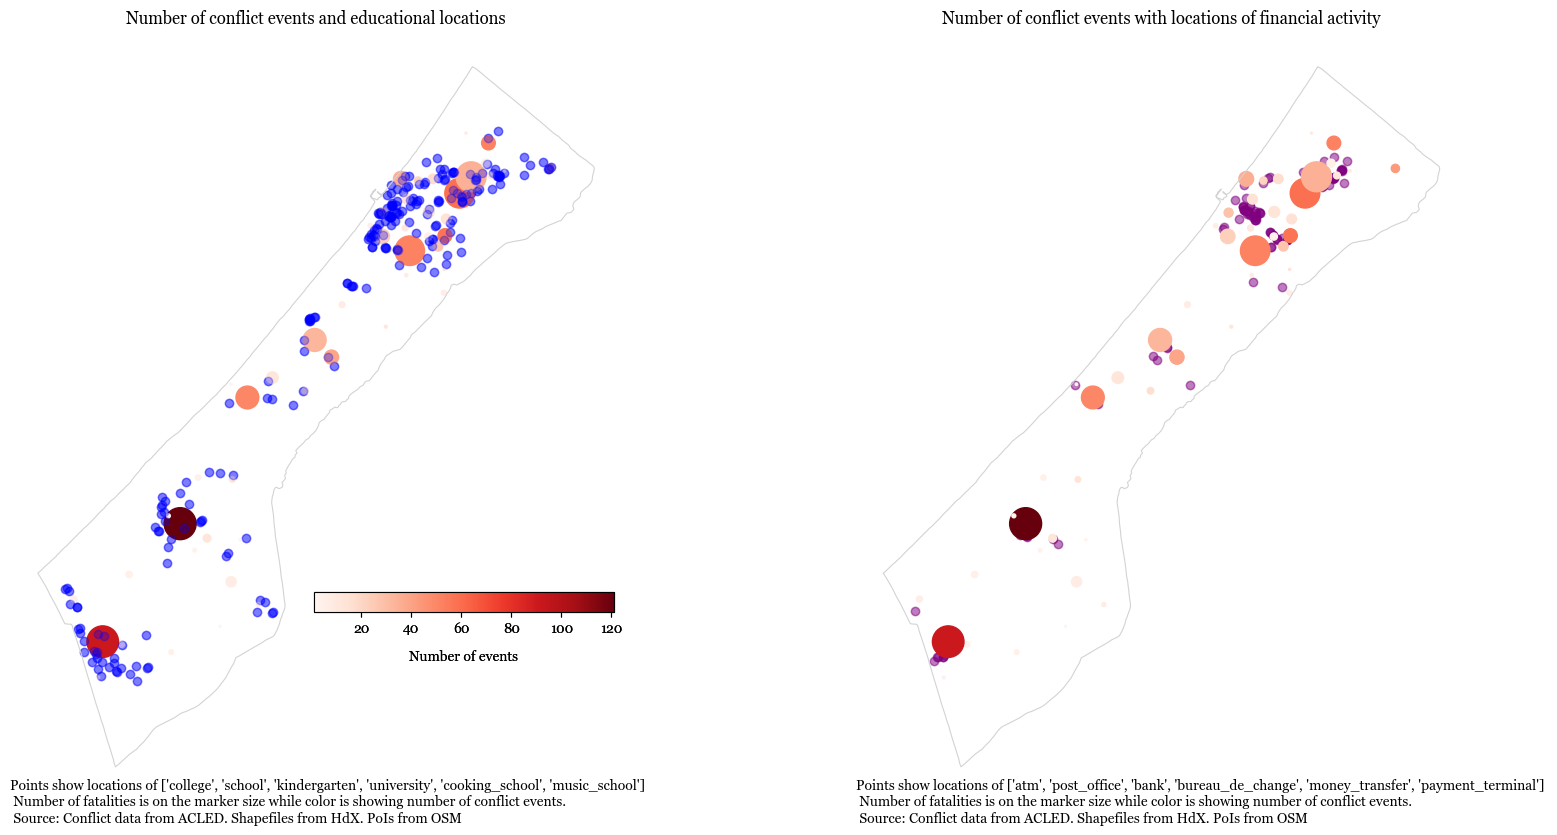

In [110]:
plt.rcParams["font.family"] = "Georgia"

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

df = acled[acled['event_date']>='2023-10-07'].sjoin(palestine_adm1).groupby(['latitude', 'longitude', 'ADM1_EN'])['fatalities'].agg(['sum', 'count']).reset_index()
df.rename(columns = {'sum':'fatalities', 'count':'nrEvents'}, inplace=True)
df = df[df['ADM1_EN']=='Gaza Strip']
df = convert_to_gdf(df)

for id, ax in enumerate(axs):
        palestine_adm1[palestine_adm1['ADM1_EN']=='Gaza Strip'].boundary.plot(ax=ax, linewidth = 0.8, color = 'lightgrey')
        
        schools_poi.plot(color='blue', ax=axs[0], alpha=0.3, legend = True)
        financial_services_poi.plot(color='purple', ax=axs[1], alpha=0.3, legend = True)

        df.plot(column='nrEvents', cmap='Reds', ax=ax, markersize='fatalities')

        cax = fig.add_axes([0.3, 0.3, 0.15, 0.02])
        norm = plt.Normalize(vmin=df['nrEvents'].min(), vmax=df['nrEvents'].max())
        cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Reds'), ax=ax, orientation='horizontal', pad=0.02, aspect = 200, cax=cax)
        cbar.set_label('Number of events', rotation=0, labelpad=10)

        # cax = fig.add_axes([0.6, 0.4, 0.15, 0.02])
        # norm = plt.Normalize(vmin=population_gaza['Z'].min(), vmax=population_gaza['Z'].max())
        # cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, orientation='horizontal', pad=0.02, aspect = 200, cax=cax)
        # cbar.set_label('Population Density', rotation=0, labelpad=10)

        ax.axis('off')

        axs[0].set_title("Number of conflict events and educational locations")
        axs[1].set_title("Number of conflict events with locations of financial activity")

        if id == 0:
            subtitle_add_on = education
        else:
              subtitle_add_on = financial_services

        subtitle = f'Points show locations of {subtitle_add_on} \n Number of fatalities is on the marker size while color is showing number of conflict events. \n Source: Conflict data from ACLED. Shapefiles from HdX. PoIs from OSM'


        ax.text(0, 0, subtitle, ha='left', va='center', transform=ax.transAxes,
                fontsize=10, color='black', weight='normal')
        
plt.savefig('../../docs/images/conflict_on_poi2.png')


In [82]:
roads = gpd.read_file('../../data/hotosm_pse_points_of_interest_points_shp/pse_trs_roads_osm/pse_trs_roads_osm.shp')
streets = gpd.read_file('../../data/hotosm_pse_points_of_interest_points_shp/pse_trs_streets_osm/pse_trs_streets_osm.shp')


In [95]:
waterways = gpd.read_file('../../data/hotosm_pse_points_of_interest_points_shp/hotosm_pse_waterways_lines_shp/hotosm_pse_waterways_lines.shp')

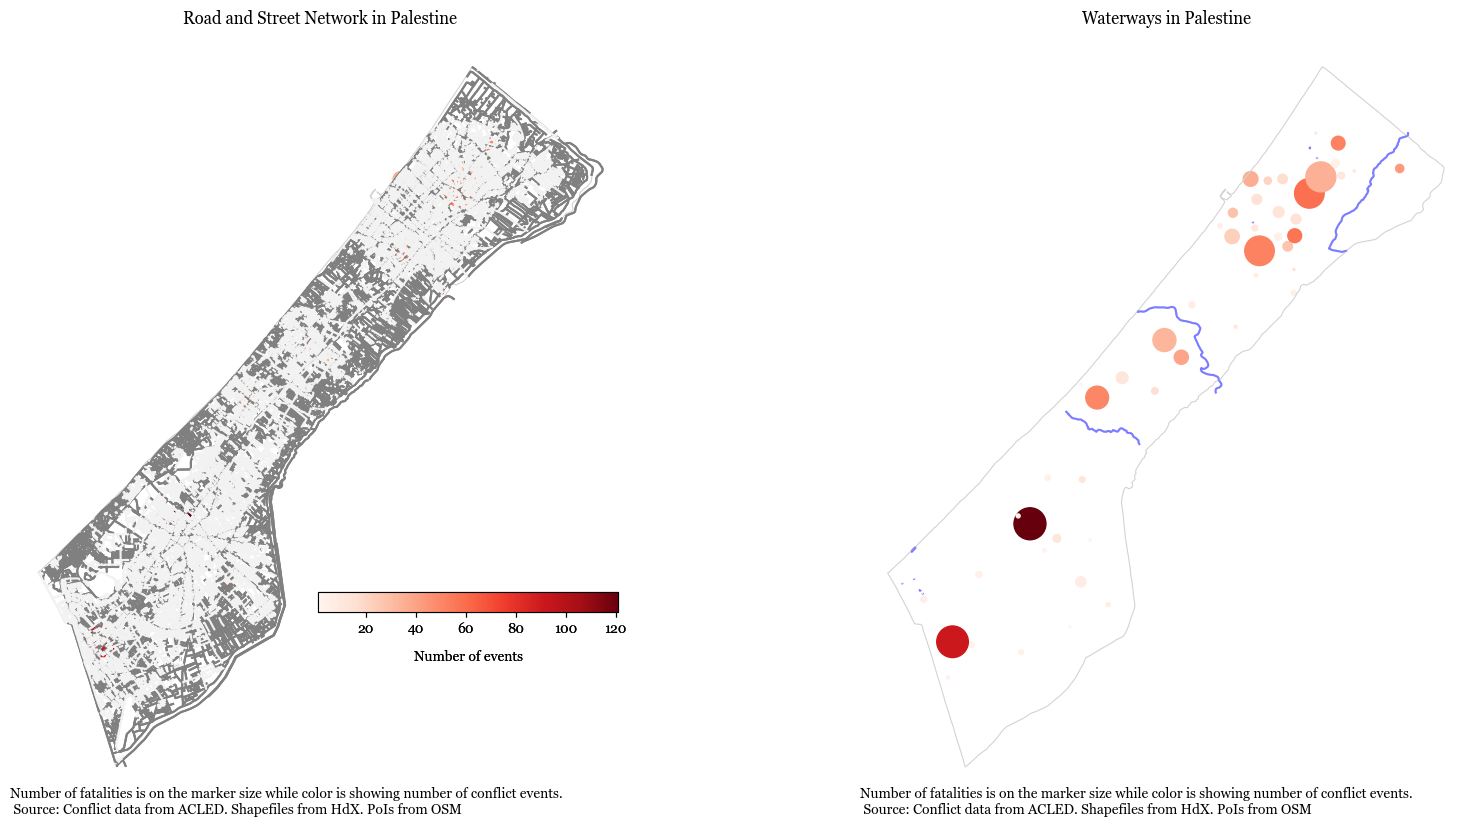

In [112]:
plt.rcParams["font.family"] = "Georgia"

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

df = acled[acled['event_date']>='2023-10-07'].sjoin(palestine_adm1).groupby(['latitude', 'longitude', 'ADM1_EN'])['fatalities'].agg(['sum', 'count']).reset_index()
df.rename(columns = {'sum':'fatalities', 'count':'nrEvents'}, inplace=True)
df = df[df['ADM1_EN']=='Gaza Strip']
df = convert_to_gdf(df)

for ax in axs:
        palestine_adm1[palestine_adm1['ADM1_EN']=='Gaza Strip'].boundary.plot(ax=ax, linewidth = 0.8, color = 'lightgrey')
        
        roads.sjoin(gaza).plot(color = 'grey', ax=axs[0])
        streets.sjoin(gaza).plot(color = '#f2f2f2', ax=axs[0])
        waterways.sjoin(gaza).plot(color='blue', ax=axs[1], alpha=0.3, legend = True)

        df.plot(column='nrEvents', cmap='Reds', ax=ax, markersize='fatalities')

        cax = fig.add_axes([0.3, 0.3, 0.15, 0.02])
        norm = plt.Normalize(vmin=df['nrEvents'].min(), vmax=df['nrEvents'].max())
        cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Reds'), ax=ax, orientation='horizontal', pad=0.02, aspect = 200, cax=cax)
        cbar.set_label('Number of events', rotation=0, labelpad=10)

        # cax = fig.add_axes([0.6, 0.4, 0.15, 0.02])
        # norm = plt.Normalize(vmin=population_gaza['Z'].min(), vmax=population_gaza['Z'].max())
        # cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, orientation='horizontal', pad=0.02, aspect = 200, cax=cax)
        # cbar.set_label('Population Density', rotation=0, labelpad=10)

        ax.axis('off')

        axs[0].set_title("Road and Street Network in Palestine")
        axs[1].set_title("Waterways in Palestine")

        subtitle = f'Number of fatalities is on the marker size while color is showing number of conflict events. \n Source: Conflict data from ACLED. Shapefiles from HdX. PoIs from OSM'

        ax.text(0, 0, subtitle, ha='left', va='center', transform=ax.transAxes,
                fontsize=10, color='black', weight='normal')
        
plt.savefig('../../docs/images/conflict_on_poi3.png')


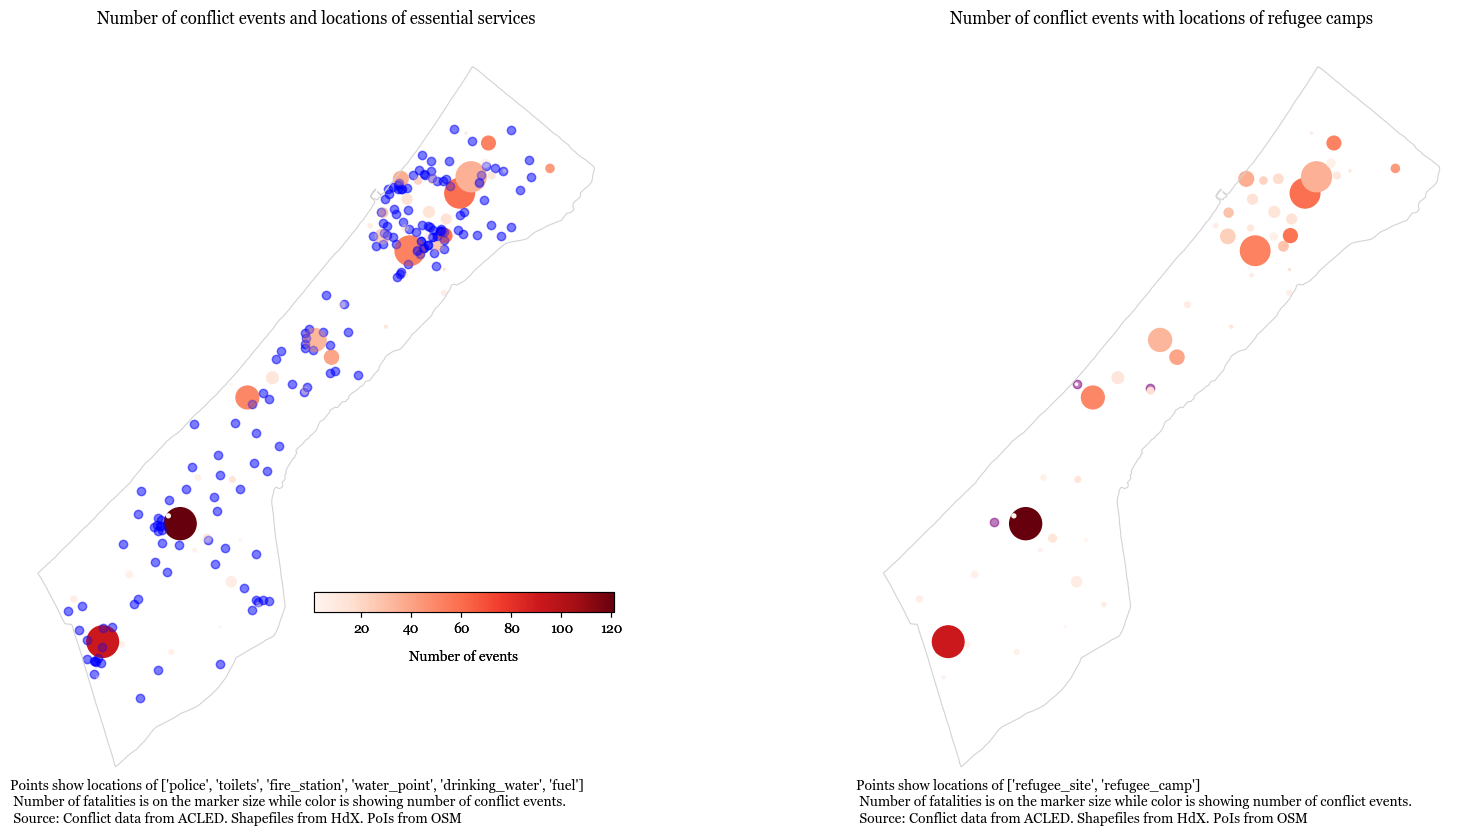

In [113]:
plt.rcParams["font.family"] = "Georgia"

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

df = acled[acled['event_date']>='2023-10-07'].sjoin(palestine_adm1).groupby(['latitude', 'longitude', 'ADM1_EN'])['fatalities'].agg(['sum', 'count']).reset_index()
df.rename(columns = {'sum':'fatalities', 'count':'nrEvents'}, inplace=True)
df = df[df['ADM1_EN']=='Gaza Strip']
df = convert_to_gdf(df)

for id, ax in enumerate(axs):
        palestine_adm1[palestine_adm1['ADM1_EN']=='Gaza Strip'].boundary.plot(ax=ax, linewidth = 0.8, color = 'lightgrey')
        
        essential_services_poi.plot(color='blue', ax=axs[0], alpha=0.3, legend = True)
        refugee_locations_poi.plot(color='purple', ax=axs[1], alpha=0.3, legend = True)

        df.plot(column='nrEvents', cmap='Reds', ax=ax, markersize='fatalities')

        cax = fig.add_axes([0.3, 0.3, 0.15, 0.02])
        norm = plt.Normalize(vmin=df['nrEvents'].min(), vmax=df['nrEvents'].max())
        cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Reds'), ax=ax, orientation='horizontal', pad=0.02, aspect = 200, cax=cax)
        cbar.set_label('Number of events', rotation=0, labelpad=10)

        # cax = fig.add_axes([0.6, 0.4, 0.15, 0.02])
        # norm = plt.Normalize(vmin=population_gaza['Z'].min(), vmax=population_gaza['Z'].max())
        # cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, orientation='horizontal', pad=0.02, aspect = 200, cax=cax)
        # cbar.set_label('Population Density', rotation=0, labelpad=10)

        ax.axis('off')

        axs[0].set_title("Number of conflict events and locations of essential services")
        axs[1].set_title("Number of conflict events with locations of refugee camps")

        if id == 0:
            subtitle_add_on = essential_services
        else:
              subtitle_add_on = refugee_locations

        subtitle = f'Points show locations of {subtitle_add_on} \n Number of fatalities is on the marker size while color is showing number of conflict events. \n Source: Conflict data from ACLED. Shapefiles from HdX. PoIs from OSM'

        ax.text(0, 0, subtitle, ha='left', va='center', transform=ax.transAxes,
                fontsize=10, color='black', weight='normal')
        
plt.savefig('../../docs/images/conflict_on_poi4.png')
